In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

In [2]:
observation_date = observation_date = dt.datetime(year=2021, month=2, day=27)

FILE_NAMES = [
    "data/{td:%y}-{td:%m}-{td:%d}-ohlc".format(td=observation_date)
    ,
]

In [3]:
## TODO: Make this actually work for multiple files
for file in FILE_NAMES:
    with open(file, 'rb') as f:
        data = np.frombuffer(f.read()).reshape(-1, 5).copy()
        data[:,0] = list(map(lambda dtbytes: int.from_bytes(dtbytes, 'little'),data[:,0]))

In [4]:
df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

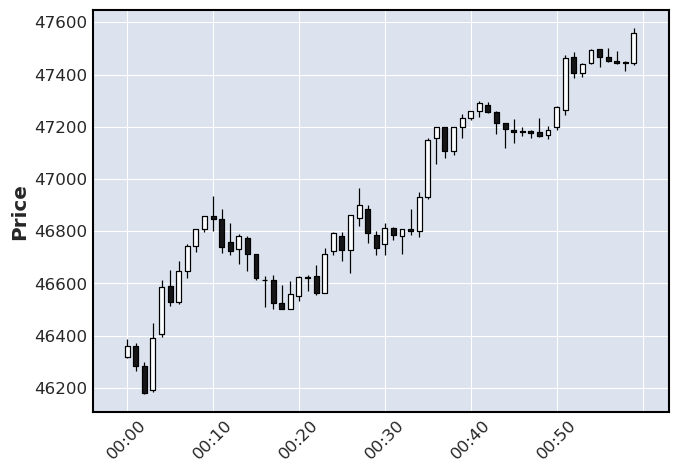

In [5]:
mpf.plot(df.set_index('timestamp')[:60], type='candle')

In [6]:
# Reshape into 4 channel timeseries
# Channels 0,1,2,3 = open, high, low, close
series = data.T[1:].reshape(4,1440)

# Normalize series between [0,1] (MinMaxScaler)
normed_series = np.empty(shape=(4,1440))
for idx, channel in enumerate(series):
    min_ = np.min(channel)
    max_ = np.max(channel)
    normed_channel = (channel - min_) / (max_ - min_)
    normed_series[idx] = normed_channel

sample = normed_series.T[:60].T

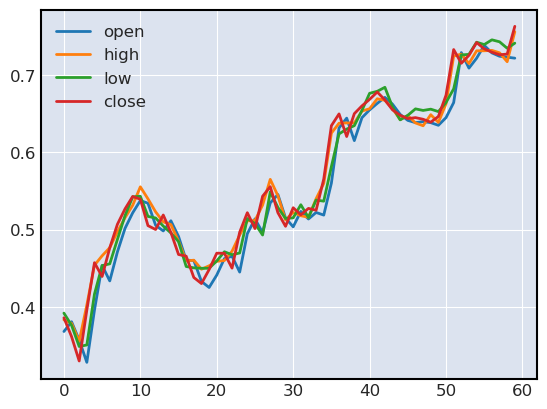

In [8]:
plt.plot(np.arange(0, len(sample[0])), sample[0], label="open")
plt.plot(np.arange(0, len(sample[1])), sample[1], label="high")
plt.plot(np.arange(0, len(sample[2])), sample[2], label="low")
plt.plot(np.arange(0, len(sample[3])), sample[3], label="close")
plt.legend()

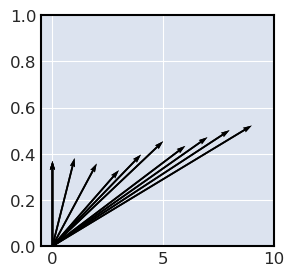

In [9]:
origin = [0,0]
X, Y = zip(origin, origin)
data = np.array([0, sample[0][0]])
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(10):
    vec = np.array([i, sample[0][i]])
    ax.quiver(X, Y, *vec, angles='xy', scale_units='xy', scale=1)
    
ax.quiver(X, Y, *data,angles='xy', scale_units='xy', scale=1)
ax.set_xlim(-0.5,10)
_ =ax.set_ylim(0, 1)

In [10]:
polar_sample = np.arccos(sample.T).T
r = np.arange(0, 1, 1/len(polar_sample[0]) )

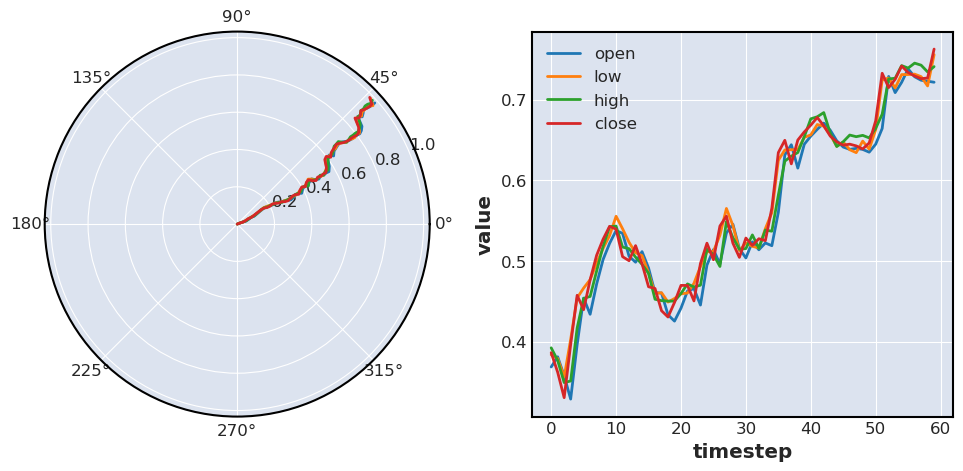

In [14]:
channels = ["open", "low", "high", "close"]
fig = plt.figure(figsize=(25,5))
axp = fig.add_subplot(141, projection='polar')
axc = fig.add_subplot(142, projection='rectilinear')
for idx, chan in enumerate(channels):
    axp.plot(sample[idx], r, label=chan)
    axc.plot(np.arange(0, len(sample[idx])), sample[idx], label=chan)
axc.set_xlabel("timestep")
axc.set_ylabel('value')
plt.legend()
plt.show()

In [50]:
gasf = lambda theta1, theta2: np.cos(theta1 + theta2)

In [51]:
gramian = np.empty((*polar_sample.shape, polar_sample.shape[-1]))

In [52]:
# TODO: Leverage symmetry here to reduce computation count
for channel in range(len(channels)):
    for idx, theta in enumerate(polar_sample[channel]):
        for idx_, theta_ in enumerate(polar_sample[channel]):
            res = gasf(theta,theta_)
            gramian[channel][idx][idx_] = res
        

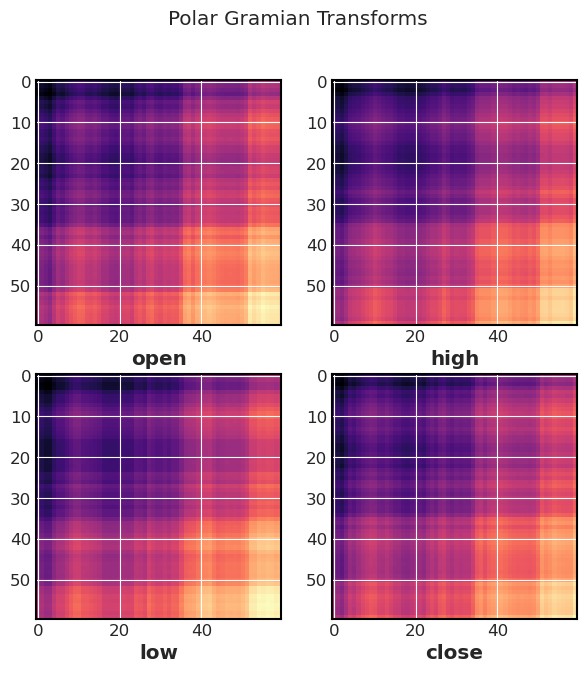

In [80]:
fig = plt.figure(figsize=(7,7))
ax_open = fig.add_subplot(221)
ax_open.imshow(gramian[0], cmap='magma')
ax_open.set_xlabel("open")
ax_high= fig.add_subplot(222)
ax_high.imshow(gramian[1], cmap='magma')
ax_high.set_xlabel("high")
ax_low = fig.add_subplot(223)
ax_low.imshow(gramian[2], cmap='magma')
ax_low.set_xlabel("low")
ax_close = fig.add_subplot(224)
ax_close.imshow(gramian[3], cmap='magma')
ax_close.set_xlabel("close")
fig.suptitle("Polar Gramian Transforms")
fig.show()

In [82]:
## WARNING: I AM NOT SURE THAT ANYTHING BELOW THIS COMMENT IS CORRECT
gasf_rectilinear = lambda x, y: np.dot(x.T, y) - np.dot(np.sqrt(np.ones(x.shape) - x**2).T
                                                        , np.sqrt(np.ones(y.shape) - y**2)) 
gramian_rectilinear = np.empty((*sample.shape, sample.shape[-1]))

In [83]:
for channel in range(len(channels)):
    for idx, val in enumerate(sample[channel]):
        x = np.array([idx/len(sample[channel]),val])
        for idx_, val_ in enumerate(sample[channel]):
            y = np.array([idx_/len(sample[channel]), val_])
            res = gasf_rectilinear(x,y)
            gramian_rectilinear[channel][idx][idx_] = res

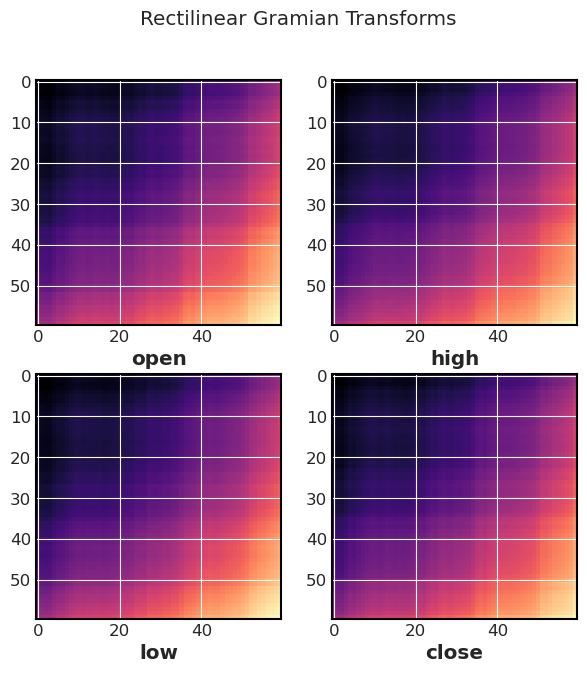

In [84]:
fig = plt.figure(figsize=(7,7))
ax_open = fig.add_subplot(221)
ax_open.imshow(gramian_rectilinear[0], cmap='magma')
ax_open.set_xlabel("open")
ax_high= fig.add_subplot(222)
ax_high.imshow(gramian_rectilinear[1], cmap='magma')
ax_high.set_xlabel("high")
ax_low = fig.add_subplot(223)
ax_low.imshow(gramian_rectilinear[2], cmap='magma')
ax_low.set_xlabel("low")
ax_close = fig.add_subplot(224)
ax_close.imshow(gramian_rectilinear[3], cmap='magma')
ax_close.set_xlabel("close")
fig.suptitle("Rectilinear Gramian Transforms")
fig.show()

In [73]:
## TODO: ^^ Why do these look more smooth? Some function of the linear space. Noiser? Compare against pure gaussian noise perhaps
## ˇˇ Investigate the difference curve. It looks like a function. Some polynomial

In [74]:
gramian[0][0][0]

-0.7283756764057443

In [75]:
gramian_rectilinear[0][0][0]

-1.728375676405744

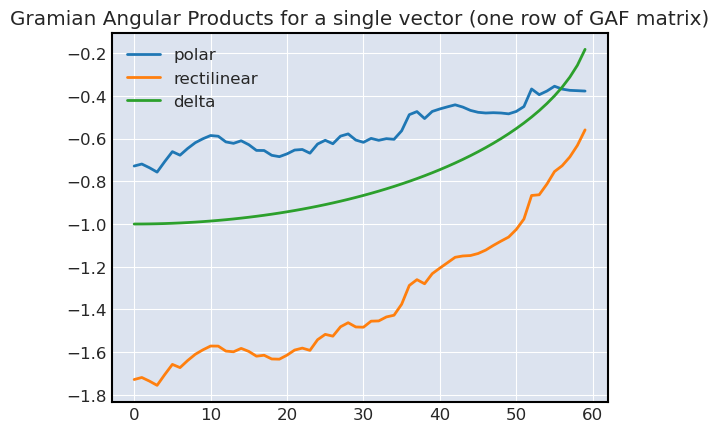

In [85]:
plt.plot(np.arange(0,len(gramian[0][0])), gramian[0][0], label="polar")
plt.plot(np.arange(0,len(gramian_rectilinear[0][0])), gramian_rectilinear[0][0], label="rectilinear")
plt.plot(np.arange(0,len(gramian_rectilinear[0][0])), gramian_rectilinear[0][0] - gramian[0][0], label="delta")
plt.legend()
plt.title("Gramian Angular Products for a single vector (one row of GAF matrix)")
plt.show()

In [86]:
## ^^ spitballing, it looks like the rectilinear penalty is not de-biasing "later" timesteps nearly as much as expected. Could be the penalty portion of the function is incorrect